### Note:
- This notebook only process three types of experiment data which are:
1. EMG measurement from three channels
2. Elbow flexion / extension

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import scipy
from scipy import signal
from scipy.signal import freqz

import math

from butterworth import band_pass, low_pass, high_pass
from utils import full_wave_rectify, plot_signal_one, plot_multiple

In [2]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
xa = np.asarray(x)
vara = (1 / (len(xa) - 1)) * np.sum([s ** 2 for s in xa])
print(vara)
a = 4
print(np.sqrt(a))

35.625
2.0


### Prepare feature extraction functions

In [3]:
a = np.arange(10, 5831, 10)
j = 0
for i in range(len(a)):
    j += 1
print(j)

583


In [4]:
def getEMGfeatures(emg, window = 1, step = 1):
    """
    emg: filtered rectified EMG signal
    window: size of sliding windows
    step: number of step between two windows
    """
    endPt = len(emg)
    pts = np.arange(window, endPt, step)
    j = 0
    for i in range(len(pts)):
        j += 1
        sampleEMG = emg[pts[i] - window + 1:pts[i], :]
        pass
        
    
def getfeaturesTD(emg):
    pass
    

### Data Preprocessing
1. Full-wave rectification
2. Remove the noise from data by using Butterworth Filter
3. Feature extraction
4. Dimensionality Reduction (*Optional)
5. Save the data as '.csv' file

In [5]:
# Setup the parameters of signal
f = 2000

In [6]:
# path = r'/home/jerry/GitHub/EMG_regressive_model/data_process/raw_data'
path = r'D:/GitHub/EMG_regressive_model/data_process/raw_data'
all_files = glob.glob(path+'/*.csv')
dfList = []

In [7]:
# Read .csv file by using panda
# for filename in all_files:
file = all_files[0]
saveName = file[-11:-4]
print(file)
allData = pd.read_csv(file, skiprows = 4, header = None)


D:/GitHub/EMG_regressive_model/data_process/raw_data\2021-06-08-13-13_CUBE elbow data collection_2.75_T_1.csv


C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# Create the dataframe for EMG data and Joint angle
emgData = allData.iloc[:, 3:6]
angleData = allData.iloc[:, 32:33]

#Convert the dataframe to numpy array
emg = emgData.to_numpy()
time = np.array([i/f for i in range(0, len(emg), 1)]) # sampling rate 2000 Hz
mean = np.mean(emg, axis = 0)
emgAvg = emg - mean

angle = angleData.to_numpy()
# Perform the full wave rectification
rectEmg = full_wave_rectify(emgAvg)
print(rectEmg.shape[-1] - 1)
bpEmg = band_pass(rectEmg, fs = f, high_band = 200, low_band = 10, order = 6, padB = True, axs = -1, pad = 0)
# features = getEMGfeatures(bpEmg, window = 10, step = 10)
# print(len(angle))
# print(len(bpEmg))
# print(angle.shape[0] - 1)
bpAngle = band_pass(angle, fs = f, high_band = 100, low_band = 10, order = 4, axs = -1, padB = True, pad = 0)


2


AssertionError: Length of signals must equal to length of time and total number of plots

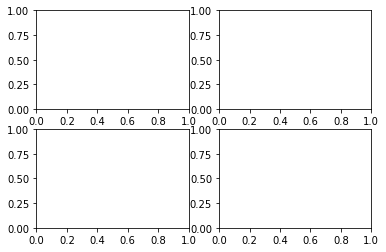

In [9]:
tit = ['EMG CH1', 'EMG CH2', 'EMG CH3']
filename = 'emgvstime.png'
plot_multiple(bpEmg, time, 3, 'Time', 'EMG', tit, filename)

In [11]:
row = 10
for i in range(11):
    for j in range(2):
        print(i, 'and', j)

0 and 0
0 and 1
1 and 0
1 and 1
2 and 0
2 and 1
3 and 0
3 and 1
4 and 0
4 and 1
5 and 0
5 and 1
6 and 0
6 and 1
7 and 0
7 and 1
8 and 0
8 and 1
9 and 0
9 and 1
10 and 0
10 and 1
